# Section: Dataset

In [6]:
import pandas as pd
import numpy as np
import random

# Set random seed for reproducibility
np.random.seed(42)

# Create the role dictionary
role_dict_inverse = {'jungler': 1, 'marksman': 2, 'midlaner': 3, 'explaner': 4, 'roamer': 5}
role_dict = {v: k for k, v in role_dict_inverse.items()}

# Generate winrate data with specified distribution
def generate_winrate_distribution(size):
    winrate_data = []
    # 15% of data with winrate 30-40
    winrate_data.extend(np.random.uniform(30, 40, int(size * 0.15)))
    # 60% of data with winrate 40-60
    winrate_data.extend(np.random.uniform(40, 60, int(size * 0.60)))
    # 20% of data with winrate 60-80
    winrate_data.extend(np.random.uniform(60, 80, int(size * 0.20)))
    # 5% of data with winrate 80-99
    winrate_data.extend(np.random.uniform(80, 99, int(size * 0.05)))
    return winrate_data

# Generate synthetic data
data = {
    'id': range(1, 10001),
    'tier': np.random.randint(1, 3, 10000),  # 1st Tier-2nd Tier
    'total_match': np.random.randint(10, 10000, 10000),
    'winrate': generate_winrate_distribution(10000),
    'most_pick_role': np.random.randint(1, 6, 10000)  # 1=jungler, 2=marksman, 3=midlaner, 4=explaner, 5=roamer
}

df = pd.DataFrame(data)
df['most_pick_role'] = df['most_pick_role'].map(role_dict)



In [7]:
print(df)

         id  tier  total_match    winrate most_pick_role
0         1     1         3132  38.393709       explaner
1         2     2         8177  39.444879        jungler
2         3     1         5200  32.729217         roamer
3         4     1         4585  31.696611         roamer
4         5     1         7737  34.839908       midlaner
...     ...   ...          ...        ...            ...
9995   9996     2         1336  94.532901         roamer
9996   9997     1         6187  89.489781       marksman
9997   9998     2         9227  93.787454       marksman
9998   9999     2          371  89.598633        jungler
9999  10000     1         1228  91.265201       explaner

[10000 rows x 5 columns]


# Section: Exploratory Data Analysis (EDA)

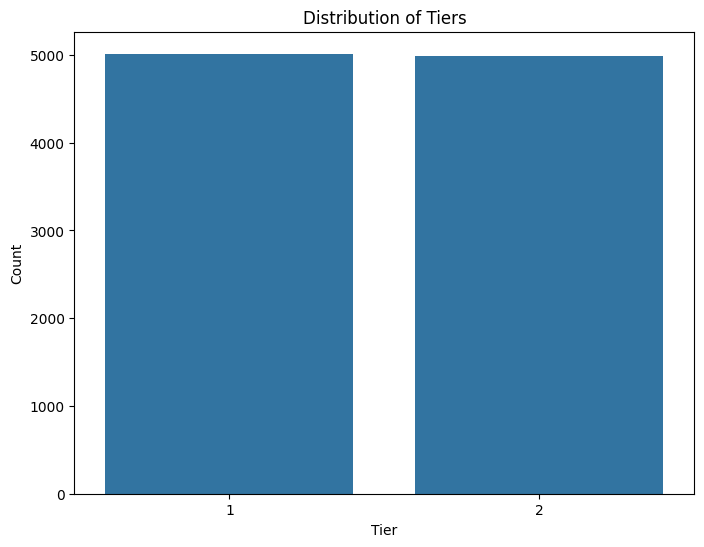

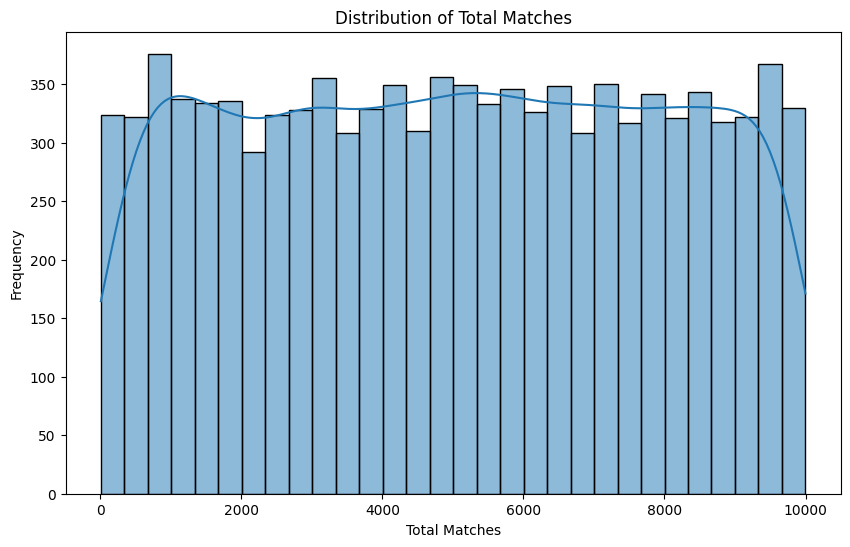

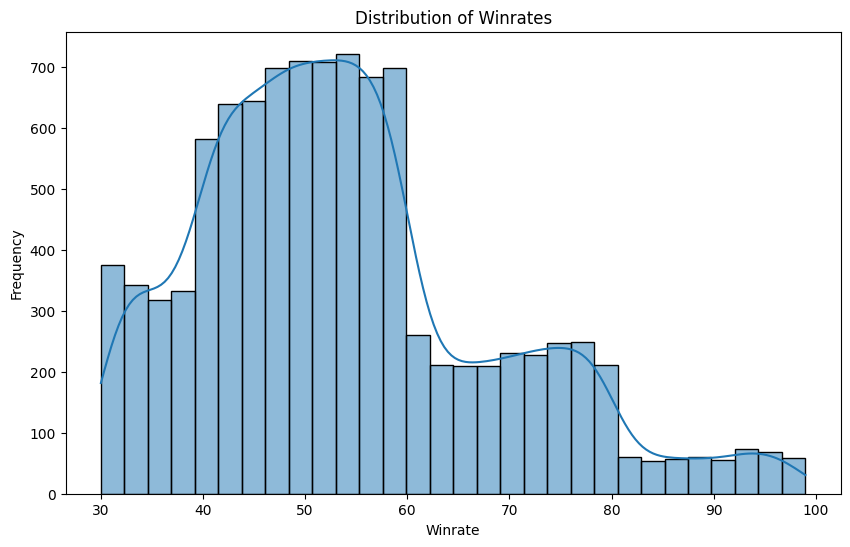

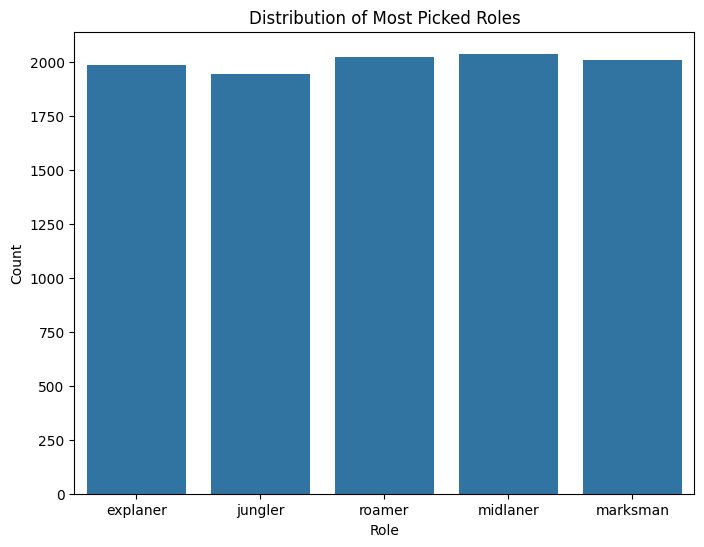

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize tier distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='tier')
plt.title('Distribution of Tiers')
plt.xlabel('Tier')
plt.ylabel('Count')
plt.show()

# Visualize total match distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='total_match', bins=30, kde=True)
plt.title('Distribution of Total Matches')
plt.xlabel('Total Matches')
plt.ylabel('Frequency')
plt.show()

# Visualize winrate distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='winrate', bins=30, kde=True)
plt.title('Distribution of Winrates')
plt.xlabel('Winrate')
plt.ylabel('Frequency')
plt.show()

# Visualize most picked role distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='most_pick_role')
plt.title('Distribution of Most Picked Roles')
plt.xlabel('Role')
plt.ylabel('Count')
plt.show()

# Section: Genetic Algorithm Setup

In [13]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
df[['tier', 'total_match', 'winrate']] = scaler.fit_transform(df[['tier', 'total_match', 'winrate']])

In [14]:
from deap import base, creator, tools, algorithms

# Function to evaluate the fitness of a team
def evaluate_team(team):
    roles = [role_dict_inverse[role] for _, role in team]
    if len(set(roles)) != len(roles):  # Ensure all roles are unique in the team
        return 0,
    return sum(df.loc[df['id'].isin([player_id for player_id, _ in team]), 'winrate']),

# Create classes for the genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Initialize toolbox
toolbox = base.Toolbox()
toolbox.register("attr_player", random.randint, 1, len(df))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_player, 5)
toolbox.register("team", tools.initRepeat, list, toolbox.individual, 2)

def init_team():
    team = []
    while len(team) < 5:
        player = random.randint(1, len(df))
        if player not in [p[0] for p in team] and df.loc[df['id'] == player, 'most_pick_role'].values[0] not in [p[1] for p in team]:
            team.append((player, df.loc[df['id'] == player, 'most_pick_role'].values[0]))
    return creator.Individual(team)

toolbox.register("individual", init_team)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_team)

d:\Program Files\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
d:\Program Files\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


# Section: Genetic Algorithm Execution

In [15]:
# Parameters for the genetic algorithm
population = toolbox.population(n=300)
NGEN = 50
CXPB, MUTPB = 0.5, 0.2

# Run the genetic algorithm
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = map(toolbox.evaluate, offspring)
    
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    population = toolbox.select(offspring, k=len(population))
    best_ind = tools.selBest(population, 1)[0]
    print(f"Gen {gen}: Best fitness: {best_ind.fitness.values[0]}")

# Extract the best individual (team) and ensure no duplicate members for the second team
best_team = tools.selBest(population, 1)[0]

# Function to ensure no duplicate players in second team
def create_second_team(exclude_players):
    while True:
        team = []
        while len(team) < 5:
            player = random.randint(1, len(df))
            if player not in exclude_players and player not in [p[0] for p in team] and df.loc[df['id'] == player, 'most_pick_role'].values[0] not in [p[1] for p in team]:
                team.append((player, df.loc[df['id'] == player, 'most_pick_role'].values[0]))
        if len(set([p[1] for p in team])) == 5:  # Ensure all roles are unique
            return creator.Individual(team)

# Exclude players in the best_team to create the second team
exclude_players = [player_id for player_id, _ in best_team]
team2 = create_second_team(exclude_players)

Gen 0: Best fitness: 4.727708792858232
Gen 1: Best fitness: 4.727708792858232
Gen 2: Best fitness: 5.629688910411083
Gen 3: Best fitness: 5.454738769566533
Gen 4: Best fitness: 5.7239503067004955
Gen 5: Best fitness: 6.96536855634021
Gen 6: Best fitness: 7.226316435920787
Gen 7: Best fitness: 7.665514177885483
Gen 8: Best fitness: 7.665514177885483
Gen 9: Best fitness: 8.032408392374236
Gen 10: Best fitness: 8.032408392374236
Gen 11: Best fitness: 8.032408392374236
Gen 12: Best fitness: 8.032408392374236
Gen 13: Best fitness: 8.032408392374236
Gen 14: Best fitness: 8.032408392374236
Gen 15: Best fitness: 9.504840631268133
Gen 16: Best fitness: 9.504840631268133
Gen 17: Best fitness: 9.504840631268133
Gen 18: Best fitness: 9.504840631268133
Gen 19: Best fitness: 9.504840631268133
Gen 20: Best fitness: 9.504840631268133
Gen 21: Best fitness: 9.504840631268133
Gen 22: Best fitness: 9.504840631268133
Gen 23: Best fitness: 9.504840631268133
Gen 24: Best fitness: 9.504840631268133
Gen 25: Be

# Section: Display Teams

In [16]:
# Display teams with proper role mapping
def display_team(team):
    return [(player_id, role_dict[role_dict_inverse[role]]) for player_id, role in team]

print("Team 1:", display_team(best_team))
print("Team 2:", display_team(team2))

Team 1: [(9393, 'marksman'), (9711, 'explaner'), (9881, 'roamer'), (9776, 'jungler'), (9294, 'midlaner')]
Team 2: [(6063, 'midlaner'), (9885, 'jungler'), (4678, 'explaner'), (745, 'roamer'), (9124, 'marksman')]


# Section: Evaluates the balance between the two teams based on the difference in average winrates

In [17]:
threshold = 3  # Threshold for the difference in winrates

def evaluate_balance(team1, team2):
    # Extract roles for each team
    roles_team1 = [role for _, role in team1]
    roles_team2 = [role for _, role in team2]
    # Check if each team has all roles covered
    unique_roles = set(roles_team1 + roles_team2)
    if len(unique_roles) != 5:
        return "Teams are unbalanced as not all roles are represented."

    # Calculate average winrate for each team
    avg_score_team1 = sum(df.loc[df['id'].isin([player_id for player_id, _ in team1]), 'winrate']) / 5
    avg_score_team2 = sum(df.loc[df['id'].isin([player_id for player_id, _ in team2]), 'winrate']) / 5
    
    # Calculate the absolute difference in average winrates between the two teams
    diff = abs(avg_score_team1 - avg_score_team2)
    
    # Check if the difference is within the threshold
    if diff <= threshold:  # Threshold for the difference in winrates
        return f"Both teams are balanced. Score difference: {diff:.2f}"
    else:
        return f"Both teams are unbalanced. Score difference: {diff:.2f}"

evaluation = evaluate_balance(best_team, team2)
print("Team Balance Evaluation:")
print(f"{evaluation} with a threshold of {threshold}")


Team Balance Evaluation:
Both teams are balanced. Score difference: 1.61 with a threshold of 3
